# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

### Import Libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.4.1
pandas version: 3.0.0
matplotlib version: 3.10.8
seaborn version: 0.13.2


### **1.1** Load the dataset

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [8]:
# loading one file
try:
    sam = pd.read_parquet('/kaggle/input/nyc-taxi-data-updrad/2023-1.parquet')
except FileNotFoundError:
    sam = pd.read_parquet("E:/Datasets/Datasets and Dictionary-NYC/trip_records/2023-1.parquet")

sam.info()

<class 'pandas.DataFrame'>
Index: 3041714 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     str           
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            float64       


How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

---

In [ ]:

import os

os.chdir("E:/Datasets/Datasets and Dictionary-NYC/trip_records")

file_list = os.listdir()
df = pd.DataFrame()
for file_name in file_list:
    try:
        print(file_name)
        file_path = os.path.join(os.getcwd(), file_name)
        mon = pd.read_parquet(file_name)
        mon['tpep_pickup_datetime'] = pd.to_datetime(mon['tpep_pickup_datetime'])
        mon['date'] = mon['tpep_pickup_datetime'].dt.date
        mon['time'] = mon['tpep_pickup_datetime'].dt.hour
        dates = set(mon['date'].to_list())
        sampled_data = pd.DataFrame()
        for d in  dates:
            for h in range(0, 24):
                hour_df = mon[(mon['date'] == d) & (mon['time'] == h)]
                if not hour_df.empty:
                    sample = hour_df.sample(frac=0.05, random_state=42)
                    sampled_data = pd.concat([sampled_data, sample])
        df = pd.concat([df, sampled_data])

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")
df

2023-1.parquet


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
# Store the df in csv/parquet
# df.to_parquet('')
df.to_parquet("nyc_taxi_sampled_final.parquet", index=False)

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [10]:
# Load the new
df = pd.read_parquet("E:/Datasets/Datasets and Dictionary-NYC/trip_records/nyc_taxi_sampled_final.parquet")

In [11]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [12]:
df.info()

<class 'pandas.DataFrame'>
Index: 3041714 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     str           
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            float64       


#### **2.1** Fixing Columns
Fix/drop any columns as you seem necessary in the below sections

**2.1.1** 
Fix the index and drop unnecessary columns

In [8]:
# Fix the index and drop any columns that are not needed
df = df.reset_index(drop=True)
df = df.drop(columns=['date', 'time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

**2.1.2**
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [9]:
# Combine the two airport fee columns
df['airport_fee'] = df['airport_fee'].combine_first(df['Airport_fee'])
df = df.drop(columns=['Airport_fee'])
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-18 00:29:28,2023-01-18 00:46:59,NaN,7.81,NaN,None,79,160,0,29.93,0.0,0.5,6.79,0.0,1.0,40.72,NaN,NaN
1,2,2023-01-18 00:16:24,2023-01-18 00:24:30,1.0,1.24,1.0,N,236,262,1,10.00,1.0,0.5,3.00,0.0,1.0,18.00,2.5,0.0
2,2,2023-01-18 00:29:45,2023-01-18 00:36:14,1.0,1.20,1.0,N,211,79,1,8.60,1.0,0.5,2.72,0.0,1.0,16.32,2.5,0.0
3,2,2023-01-18 00:02:15,2023-01-18 00:33:00,1.0,7.07,1.0,N,114,7,1,35.20,1.0,0.5,10.05,0.0,1.0,50.25,2.5,0.0
4,1,2023-01-18 00:46:36,2023-01-18 01:03:25,1.0,3.00,1.0,N,233,143,1,18.40,3.5,0.5,1.00,0.0,1.0,24.40,2.5,0.0


**2.1.3**
Fix columns with negative (monetary) values

In [13]:
# check where values of fare amount are negative
(df['fare_amount'] < 0).sum()

np.int64(0)

Did you notice something different in the `RatecodeID` column for above records?

In [14]:
# Analyse RatecodeID for the negative fare amounts
df.loc[df['RatecodeID'] == 99.0, 'RatecodeID'] = 1
df['RatecodeID'].value_counts()

RatecodeID
1.0    2829880
2.0     112541
5.0      14649
3.0       8654
4.0       4298
6.0          6
Name: count, dtype: int64

In [15]:
# Find which columns have negative values
col = ['passenger_count', 'trip_distance','store_and_fwd_flag', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee']
y = {}
for i in col:
    if pd.api.types.is_any_real_numeric_dtype(df[i]):
        y[i] = (df[i] < 0).sum()
y

{'passenger_count': np.int64(0),
 'trip_distance': np.int64(0),
 'fare_amount': np.int64(0),
 'extra': np.int64(0),
 'mta_tax': np.int64(153),
 'tip_amount': np.int64(0),
 'tolls_amount': np.int64(0),
 'improvement_surcharge': np.int64(163),
 'total_amount': np.int64(163),
 'congestion_surcharge': np.int64(116),
 'airport_fee': np.int64(39)}

In [16]:
# fix these negative values
x = fee_cols = [
    'extra',
    'mta_tax',
    'improvement_surcharge',
    'congestion_surcharge',
    'airport_fee'
]
for i in x:
    df.loc[df[i] < 0, i] = 0

In [17]:
### Total_amount
df['total_amount'] = (
    df['fare_amount']
    + df['extra']
    + df['mta_tax']
    + df['tip_amount']
    + df['tolls_amount']
    + df['improvement_surcharge']
    + df['congestion_surcharge']
    + df['airport_fee']
)

In [18]:
y = {}
for i in col:
    if pd.api.types.is_any_real_numeric_dtype(df[i]):
        y[i] = (df[i] < 0).sum()
y

{'passenger_count': np.int64(0),
 'trip_distance': np.int64(0),
 'fare_amount': np.int64(0),
 'extra': np.int64(0),
 'mta_tax': np.int64(0),
 'tip_amount': np.int64(0),
 'tolls_amount': np.int64(0),
 'improvement_surcharge': np.int64(0),
 'total_amount': np.int64(0),
 'congestion_surcharge': np.int64(0),
 'airport_fee': np.int64(0)}

### **2.2** Handling Missing Values

**2.2.1**
Find the proportion of missing values in each column




In [19]:
# Find the proportion of missing values in each column
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71686
trip_distance                0
RatecodeID               71686
store_and_fwd_flag       71686
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount             71686
congestion_surcharge     71686
airport_fee              71686
dtype: int64

**2.2.2**
Handling missing values in `passenger_count`

In [20]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
mode_value = df['passenger_count'].mode()[0]
df['passenger_count'] = df['passenger_count'].fillna(mode_value)
df['passenger_count'].isnull().sum()
df.loc[df['passenger_count'] == 0, 'passenger_count'] = mode_value
df['passenger_count'].value_counts()

passenger_count
1.0    2364761
2.0     447710
3.0     105436
4.0      53124
5.0      42580
6.0      28083
8.0         13
7.0          6
9.0          1
Name: count, dtype: int64

Did you find zeroes in passenger_count? Handle these.

**2.2.3**
Handle missing values in `RatecodeID`

In [21]:
# Fix missing values in 'RatecodeID'
df.loc[df['RatecodeID'] == 99, 'RatecodeID'] = 1
df['RatecodeID'].value_counts().sort_index()
df['RatecodeID'] = df['RatecodeID'].fillna(1.0)
df['RatecodeID'].isnull().sum()

np.int64(0)

**2.2.4**
Impute NaN in `congestion_surcharge`

In [22]:
# handle null values in congestion_surcharge
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [23]:
# Handle any remaining missing values
df['store_and_fwd_flag'].value_counts()
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna('N')
df['airport_fee'] = df['airport_fee'].fillna(0.00)
df['total_amount'] = df['total_amount'].fillna(0)

In [24]:
df['total_amount'] = (
    df['fare_amount']
    + df['extra']
    + df['mta_tax']
    + df['tip_amount']
    + df['tolls_amount']
    + df['improvement_surcharge']
    + df['congestion_surcharge']
    + df['airport_fee']
)

In [25]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

### **2.3** Handling Outliers

Before we start fixing outliers, let's perform outlier analysis.

In [26]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,3.041714e+06,3041714,3041714,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06,3.041714e+06
mean,1.727994e+00,2023-01-17 00:25:41.237371,2023-01-17 00:41:23.730543,1.371114e+00,3.855076e+00,1.066202e+00,1.664277e+02,1.644445e+02,1.176704e+00,1.867674e+01,1.558292e+00,4.963302e-01,3.394887e+00,5.263212e-01,9.984160e-01,2.801375e+01,2.255528e+00,1.072422e-01
min,1.000000e+00,2008-12-31 23:01:42,2009-01-01 14:29:11,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2023-01-09 16:26:13,2023-01-09 16:41:19.250000,1.000000e+00,1.070000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.610000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2023-01-17 08:45:54,2023-01-17 09:01:55.500000,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.750000e+00,0.000000e+00,1.000000e+00,2.090000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2023-01-24 16:28:13.750000,2023-01-24 16:44:41,1.000000e+00,3.340000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.940000e+01,2.500000e+00,0.000000e+00
max,2.000000e+00,2023-02-01 00:56:53,2023-02-02 09:28:47,9.000000e+00,2.589281e+05,6.000000e+00,2.650000e+02,2.650000e+02,4.000000e+00,1.160100e+03,1.250000e+01,5.316000e+01,3.808000e+02,1.969900e+02,1.000000e+00,1.169400e+03,2.500000e+00,1.250000e+00
std,4.449931e-01,NaN,NaN,8.720093e-01,2.506002e+02,3.658141e-01,6.424514e+01,6.993147e+01,4.879234e-01,1.740004e+01,1.778291e+00,5.312178e-02,3.824425e+00,2.015350e+00,3.489939e-02,2.161988e+01,7.425728e-01,3.500741e-01


**2.3.1**
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [27]:
# remove passenger_count > 6
df['passenger_count'].describe()
df = df.drop(df[df['passenger_count'] > 6].index)
df['passenger_count'].describe()

count    3.041694e+06
mean     1.371073e+00
std      8.718576e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.000000e+00
Name: passenger_count, dtype: float64

In [28]:
# Continue with outlier handling
bad_entry = df[(df['fare_amount'] > 300) & (df['trip_distance'] < 0.1)]
bad_index = bad_entry.index
df = df.drop(bad_index)
df = df.drop(df[df['trip_distance'] >= 250].index)
df = df.drop(df[(df['trip_distance'] == 0) & (df['DOLocationID'] != df['PULocationID']) & (df['trip_distance'] == 0)].index)
df = df.drop(df[df['payment_type'] <= 0].index)
df =df.drop(df[df['fare_amount'] <= 0].index)
df = df.drop(df[df['fare_amount'] >= 500].index)
df = df.drop_duplicates()

In [29]:
# Do any columns need standardising?
df['total_amount'] = (df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount']
                      + df['tolls_amount'] + df['improvement_surcharge'] + df['congestion_surcharge'] + df['airport_fee'])
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

## **3** Exploratory Data Analysis

In [30]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,2.954732e+06,2954732,2954732,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06,2.954732e+06
mean,1.730789e+00,2023-01-17 00:33:57.177318,2023-01-17 00:49:36.318823,1.381058e+00,3.388725e+00,1.066159e+00,1.665318e+02,1.645278e+02,1.204415e+00,1.858830e+01,1.594896e+00,4.965365e-01,3.393941e+00,5.246661e-01,9.988005e-01,2.802259e+01,2.315391e+00,1.100599e-01
min,1.000000e+00,2008-12-31 23:01:42,2009-01-01 14:29:11,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.010000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2023-01-09 16:33:11,2023-01-09 16:48:07.750000,1.000000e+00,1.080000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.610000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2023-01-17 08:46:02.500000,2023-01-17 09:02:00.500000,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.740000e+00,0.000000e+00,1.000000e+00,2.090000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2023-01-24 16:24:17.250000,2023-01-24 16:40:42,1.000000e+00,3.320000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.980000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.940000e+01,2.500000e+00,0.000000e+00
max,2.000000e+00,2023-02-01 00:56:53,2023-02-02 09:28:47,6.000000e+00,1.598500e+02,6.000000e+00,2.650000e+02,2.650000e+02,4.000000e+00,4.979000e+02,1.250000e+01,5.316000e+01,3.808000e+02,1.969900e+02,1.000000e+00,5.468000e+02,2.500000e+00,1.250000e+00
std,4.435497e-01,NaN,NaN,8.815724e-01,4.410719e+00,3.615614e-01,6.403066e+01,6.987407e+01,4.564110e-01,1.728169e+01,1.784149e+00,5.243690e-02,3.829580e+00,2.012027e+00,2.925365e-02,2.156033e+01,6.537905e-01,3.542058e-01


In [31]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends

**3.1.1**
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: categorical
* `tpep_pickup_datetime`: Temporal
* `tpep_dropoff_datetime`: Temporal
* `passenger_count`: Numerical
* `trip_distance`: Numerical
* `RatecodeID`: Categorical
* `PULocationID`: Categorical
* `DOLocationID`: Categorical
* `payment_type`: Categorical
* `pickup_hour`: Categorical
* `trip_duration`: Numerical


The following monetary parameters belong in the same category, is it categorical or numerical?
    Numerical data
* `fare_amount` 
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2**
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [32]:
# Find and show the daily trends in taxi pickups (days of the week)

df['week_day_name'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
x = df['week_day_name'].value_counts().sort_values()
x = x.reset_index()
print(x)

  week_day_name   count
0        Monday  390173
1     Wednesday  401503
2        Friday  419048
3        Sunday  419216
4      Thursday  424905
5      Saturday  426450
6       Tuesday  473437


In [33]:
# Find and show the hourly trends in taxi pickups
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
x = df['pickup_hour'].value_counts().sort_values()
x = x.reset_index()
print(x)

    pickup_hour   count
0             4   16404
1             5   16636
2             3   25814
3             2   39762
4             6   40972
5             1   56859
6             0   81273
7             7   81726
8            23  110520
9             8  110751
10            9  125865
11           10  138998
12           22  142542
13           11  149187
14           21  156336
15           20  160633
16           12  164421
17           13  173281
18           14  185923
19           19  186463
20           16  189547
21           15  190524
22           17  202155
23           18  208140


In [34]:
# Show the monthly trends in pickups
df['month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month_name()
df['month'].value_counts().sort_values()

month
February         10
October          10
December         26
January     2954686
Name: count, dtype: int64

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [35]:
# Analyse the above parameters
y = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']
for i in y:
    print(f'{i}')
    print(f'{df[i].describe()}\n')

fare_amount
count    2.954732e+06
mean     1.858830e+01
std      1.728169e+01
min      1.000000e-02
25%      8.600000e+00
50%      1.280000e+01
75%      1.980000e+01
max      4.979000e+02
Name: fare_amount, dtype: float64

tip_amount
count    2.954732e+06
mean     3.393941e+00
std      3.829580e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.740000e+00
75%      4.200000e+00
max      3.808000e+02
Name: tip_amount, dtype: float64

total_amount
count    2.954732e+06
mean     2.802259e+01
std      2.156033e+01
min      1.010000e+00
25%      1.610000e+01
50%      2.090000e+01
75%      2.940000e+01
max      5.468000e+02
Name: total_amount, dtype: float64

trip_distance
count    2.954732e+06
mean     3.388725e+00
std      4.410719e+00
min      0.000000e+00
25%      1.080000e+00
50%      1.800000e+00
75%      3.320000e+00
max      1.598500e+02
Name: trip_distance, dtype: float64



Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3**
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [36]:
# Create a df with non zero entries for the selected parameters.
df = df[(df['fare_amount'] != 0) & (df['total_amount'] != 0)]
df[['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']].min()

fare_amount      0.01
tip_amount       0.00
total_amount     1.01
trip_distance    0.00
dtype: float64

**3.1.4**
Analyse the monthly revenue (`total_amount`) trend

In [37]:
# Group data by month and analyse monthly revenue
total_amount = df.groupby('month')['total_amount'].sum().sort_values(ascending=True)
print('total amount sum in ascending order')
print(total_amount)

total amount sum in ascending order
month
February         313.81
October          670.13
December         738.78
January     82797528.92
Name: total_amount, dtype: float64


**3.1.5**
Show the proportion of each quarter of the year in the revenue

In [35]:
# Calculate proportion of each quarter
df['month_quarter'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.quarter
quarter_amount = df.groupby('month_quarter')['total_amount'].sum().sort_values
print('monthly quarter sales in acesending order')
print(quarter_amount)

monthly quarter sales in acesending order
<bound method Series.sort_values of month_quarter
1    12741220.15
2    14393264.66
3    12213928.07
4    14399112.24
Name: total_amount, dtype: float64>


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

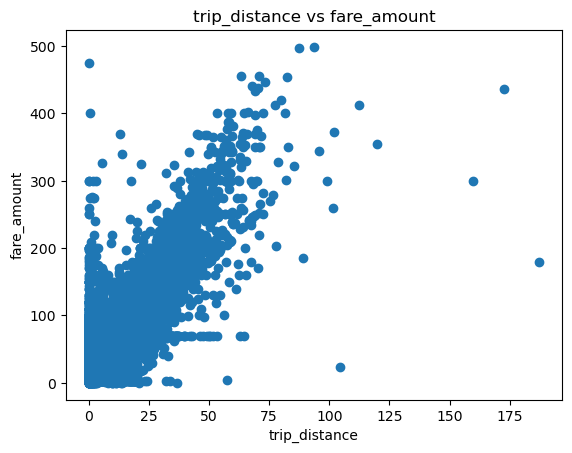

In [36]:
# Show how trip fare is affected by distance
trip_df = df.drop(df[df['trip_distance'] == 0].index)

plt.figure()
plt.scatter(trip_df['trip_distance'], trip_df['fare_amount'])
plt.xlabel('trip_distance')
plt.ylabel('fare_amount')
plt.title('trip_distance vs fare_amount')
plt.show()

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [39]:
df["trip_duration"] = pd.to_datetime(df['tpep_dropoff_datetime']) - pd.to_datetime(df['tpep_pickup_datetime'])
df['trip_duration'] = df['trip_duration'].dt.total_seconds() / 60
df = df[df['trip_duration'] > 0]
df = df[df['trip_duration']<= 2000 ]
df['trip_duration'].describe()

count    1.822979e+06
mean     1.732446e+01
std      4.031954e+01
min      1.666667e-02
25%      7.600000e+00
50%      1.253333e+01
75%      2.048333e+01
max      1.759517e+03
Name: trip_duration, dtype: float64

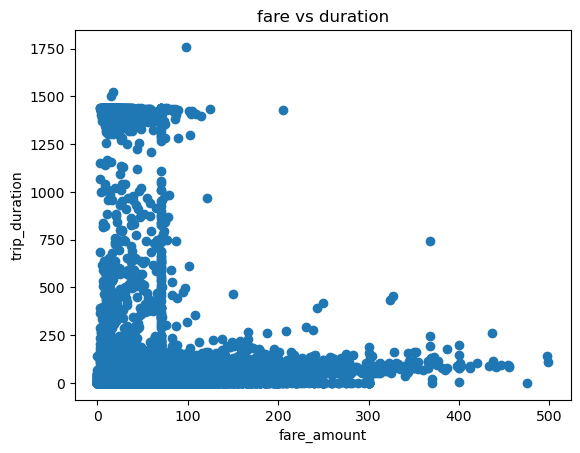

In [40]:
# Show relationship between fare and trip duration
plt.figure()
plt.scatter(df['fare_amount'], df['trip_duration'])
plt.xlabel('fare_amount')
plt.ylabel('trip_duration')
plt.title('fare vs duration')
plt.show()

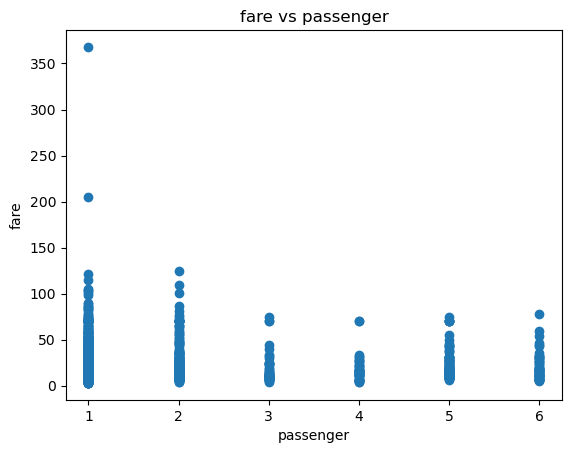

In [38]:
# Show relationship between fare and number of passengers
plt.figure()
plt.scatter(df['passenger_count'], df['fare_amount'])
plt.ylabel('fare')
plt.xlabel('passenger')
plt.title('fare vs passenger')
plt.show()

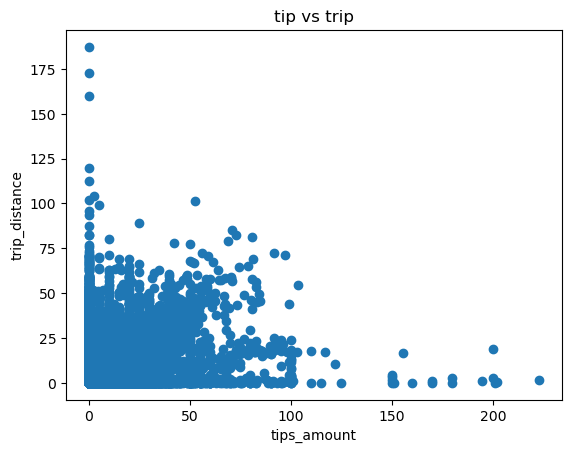

In [56]:
# Show relationship between tip and trip distance
plt.figure()
plt.scatter(df['tip_amount'], df['trip_distance'])
plt.xlabel('tips_amount')
plt.ylabel('trip_distance')
plt.title('tip vs trip')
plt.show()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [57]:
df['payment_type'].value_counts()

payment_type
1    1486221
2     314688
4      13389
3       8690
Name: count, dtype: int64

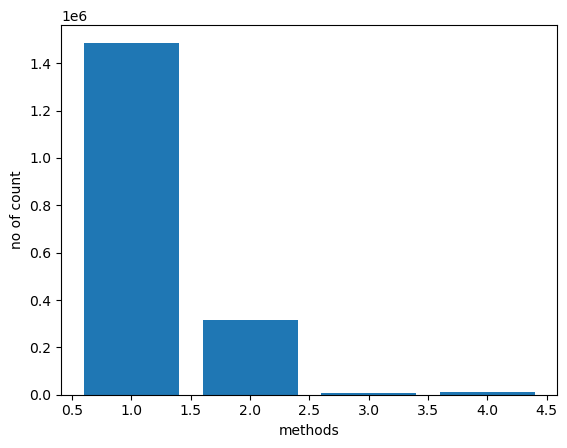

In [58]:
# Analyse the distribution of different payment types (payment_type).
values = df['payment_type'].value_counts()
plt.figure()
plt.bar(values.index, values.values)
plt.ylabel('no of count')
plt.xlabel('methods')
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [59]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [60]:
import geopandas as gpd
# Read the shapefile using geopandas

zones = gpd.read_file('taxi_zones.shp') # read the .shp file using gpd
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

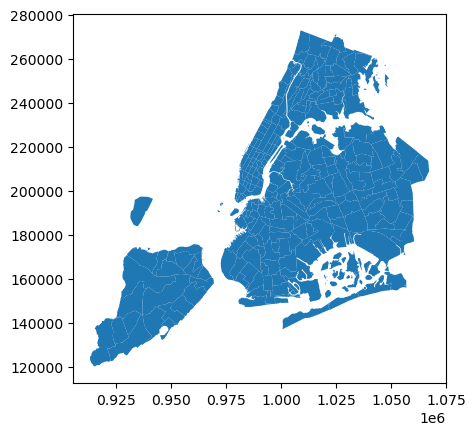

In [61]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [62]:
# Merge zones and trip records using locationID and PULocationID
df_merged = df.merge(zones, left_on= 'PULocationID', right_on='LocationID', how='left') 
df_merged.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,month,month_quarter,trip_duration,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,2,2023-01-18 00:16:24,2023-01-18 00:24:30,1.0,1.24,1.0,N,236,262,1,...,January,1,8.100000,236.0,0.044252,0.000103,Upper East Side North,236.0,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220..."
1,2,2023-01-18 00:29:45,2023-01-18 00:36:14,1.0,1.20,1.0,N,211,79,1,...,January,1,6.483333,211.0,0.025235,0.000040,SoHo,211.0,Manhattan,"POLYGON ((983827.65 201526.658, 983727.737 201..."
2,2,2023-01-18 00:02:15,2023-01-18 00:33:00,1.0,7.07,1.0,N,114,7,1,...,January,1,30.750000,114.0,0.031727,0.000047,Greenwich Village South,114.0,Manhattan,"POLYGON ((986306.712 203122.786, 986300.242 20..."
3,1,2023-01-18 00:46:36,2023-01-18 01:03:25,1.0,3.00,1.0,N,233,143,1,...,January,1,16.816667,233.0,0.048036,0.000116,UN/Turtle Bay South,233.0,Manhattan,"MULTIPOLYGON (((993816.792 213230.43, 993857.4..."
4,1,2023-01-18 00:11:48,2023-01-18 00:20:14,1.0,1.50,1.0,N,142,141,2,...,January,1,8.433333,142.0,0.038176,0.000076,Lincoln Square East,142.0,Manhattan,"POLYGON ((989380.305 218980.247, 989359.803 21..."


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [63]:
# Group data by location and calculate the number of trips
trip_count = df_merged.groupby('LocationID')['VendorID'].count().sort_values(ascending=False)
trip_count = trip_count.reset_index()
trip_count.columns = ['LocationID', "No_of_trips"]
trip_count

,LocationID,No_of_trips
0,132.0,96470
1,237.0,86706
2,161.0,85684
3,236.0,77319
4,162.0,65450
...,...,...
249,27.0,1
250,115.0,1
251,84.0,1
252,172.0,1


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [64]:
# Merge trip counts back to the zones GeoDataFrame
zones_trips = zones.merge(trip_count, on='LocationID', how='left')
zones_trips['No_of_trips'] = zones_trips['No_of_trips'].fillna(0)
zones_trips

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,No_of_trips
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",199.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",34.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",1843.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",10.0
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",41.0
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",339.0
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",9564.0
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",23556.0


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

<Axes: >

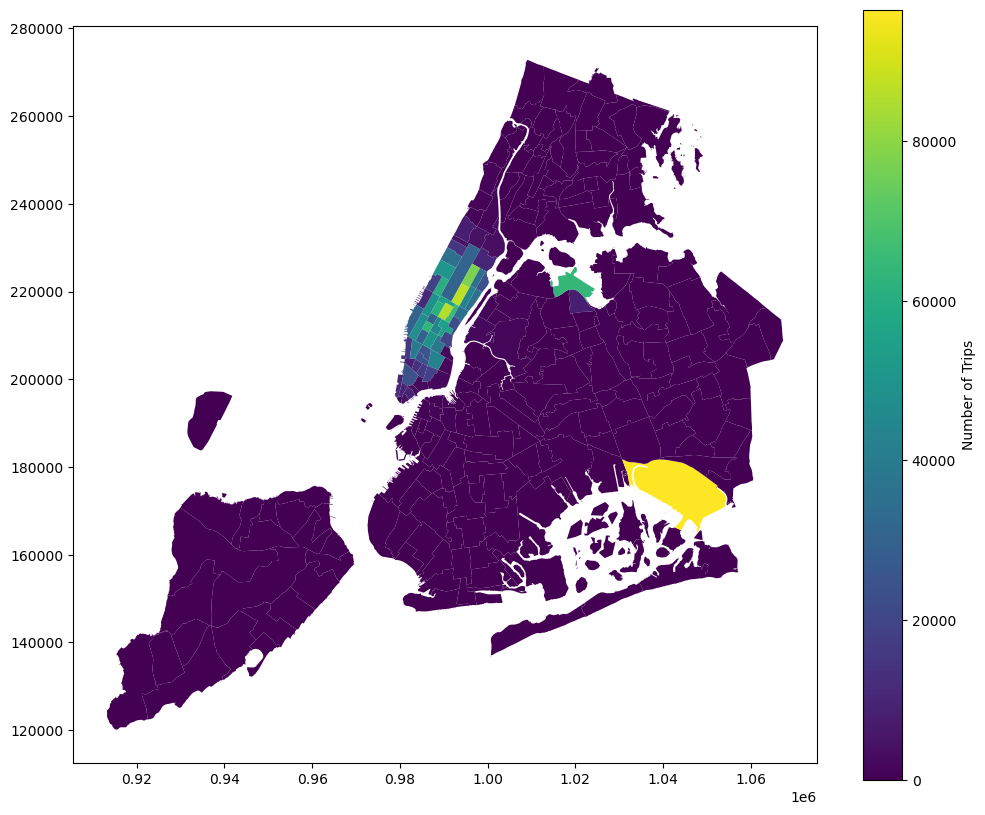

In [65]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# Plot the map and display it
zones_trips.plot(
    column='No_of_trips',
    ax=ax,
    legend=True,
    legend_kwds={
        'label': "Number of Trips",
        'orientation': "vertical"
    }
)

In [66]:
# can you try displaying the zones DF sorted by the number of trips?
zones_sorted = zones_trips.sort_values(by='No_of_trips', ascending=False)
zones_sorted.head(20)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,No_of_trips
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",96470.0
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",86706.0
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",85684.0
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220...",77319.0
161,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",65450.0
137,138,0.107467,0.000537,LaGuardia Airport,138,Queens,"MULTIPOLYGON (((1019904.219 225677.983, 102031...",64054.0
185,186,0.024696,0.000037,Penn Station/Madison Sq West,186,Manhattan,"POLYGON ((986752.603 210853.699, 986627.863 21...",63228.0
229,230,0.031028,0.000056,Times Sq/Theatre District,230,Manhattan,"POLYGON ((988786.877 214532.094, 988650.277 21...",61093.0
141,142,0.038176,0.000076,Lincoln Square East,142,Manhattan,"POLYGON ((989380.305 218980.247, 989359.803 21...",60684.0
169,170,0.045769,0.000074,Murray Hill,170,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21...",54296.0


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [67]:
# Find routes which have the slowest speeds at different times of the day
df = df[df['trip_distance'] > 0]
df['speed'] = df['trip_distance'] / (df['trip_duration'] / 60)
df['route'] = df['PULocationID'].astype(str) + "-" + df['DOLocationID'].astype(str)
x = df.groupby(['pickup_hour', "route"])['speed'].mean()
x = x.reset_index()
x = x.sort_values(by=['pickup_hour', 'speed'], ascending=[True, True])
x = x.groupby('pickup_hour').first()
x

,route,speed
pickup_hour,,
0,101-5,0.604940
1,258-258,0.026230
2,144-100,0.121962
3,151-151,0.180000
4,237-238,0.120376
5,142-142,0.023770
6,70-138,0.085750
7,128-128,0.115385
8,100-7,0.039470


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

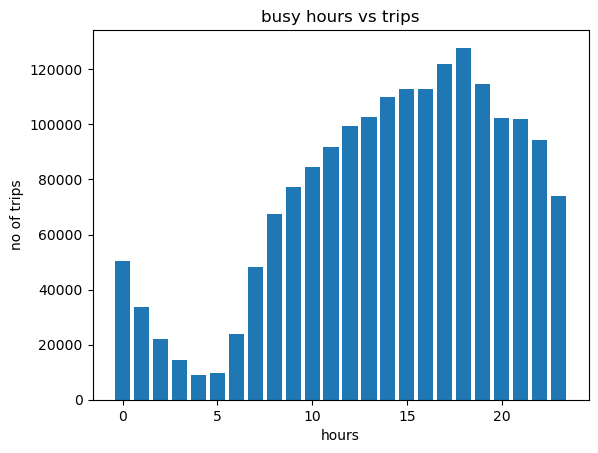

In [68]:
# Visualise the number of trips per hour and find the busiest hour
no_trips = df['pickup_hour'].value_counts()
no_trips = no_trips.sort_values().sort_index()
plt.figure()
plt.bar(no_trips.index, no_trips.values)
plt.ylabel('no of trips')
plt.xlabel('hours')
plt.title('busy hours vs trips')
plt.show()

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [69]:
# Scale up the number of trips
fraction = 0.05
# Fill in the value of your sampling fraction and use that to scale up the numbers
trips_per_hour = df['pickup_hour'].value_counts()
top_5 = trips_per_hour.sort_values(ascending=False).head(5)
top_5
actual_top_5 = top_5 / fraction
actual_top_5
df['week_day_name'].value_counts()

week_day_name
Thursday     283791
Wednesday    278161
Friday       267951
Saturday     262755
Tuesday      262584
Sunday       227188
Monday       225610
Name: count, dtype: int64

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

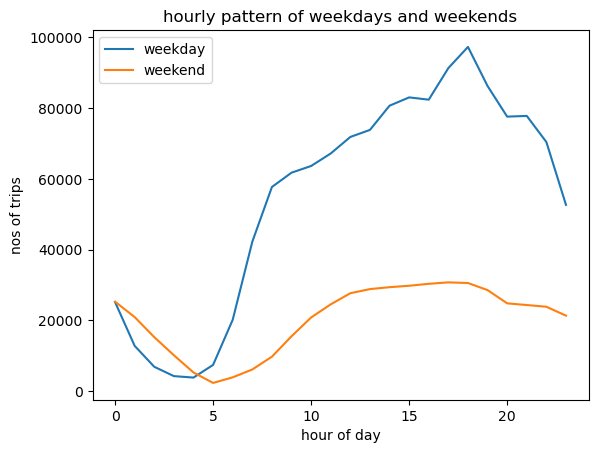

In [70]:
# Compare traffic trends for the week days and weekends
weekday = ['Thursday', 'Wednesday', 'Friday', 'Tuesday', 'Monday']
weekend = ['Saturday', 'Sunday']
weekend_df = df[df['week_day_name'].isin(weekend)]
weekday_df = df[df['week_day_name'].isin(weekday)]
weekend_trips = weekend_df['pickup_hour'].value_counts()
weekend_trips = weekend_trips.sort_index()
weekday_trips = weekday_df['pickup_hour'].value_counts()
weekday_trips = weekday_trips.sort_index()
plt.plot(weekday_trips.index, weekday_trips.values, label='weekday')
plt.plot(weekend_trips.index, weekend_trips.values, label='weekend')
plt.xlabel('hour of day')
plt.ylabel('nos of trips')
plt.title('hourly pattern of weekdays and weekends')
plt.legend()
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [71]:
# Find top 10 pickup and dropoff zones
top_pickup = df['PULocationID'].value_counts().head(10)
top_drop = df['DOLocationID'].value_counts().head(10)
print(f'\ntop pick up\n{top_pickup}')
print(f'\ntop drop off\n{top_drop}')


top pick up
PULocationID
132    94932
237    86470
161    85399
236    77116
162    65208
138    63682
186    62988
230    60729
142    60507
170    54032
Name: count, dtype: int64

top drop off
DOLocationID
236    80874
237    77143
161    71151
230    55861
170    53888
162    51853
142    51177
239    50977
141    48194
68     45934
Name: count, dtype: int64


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [72]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
top_pickup = df['PULocationID'].value_counts()
top_drop = df['DOLocationID'].value_counts()
pick_drop = top_pickup.to_frame(name='pickup')
pick_drop['drop'] = top_drop
pick_drop = pick_drop.fillna(0)
pick_drop = pick_drop.drop(pick_drop[pick_drop['drop'] == 0].index)
pick_drop['ratio'] = pick_drop['pickup'] / pick_drop['drop']
top_10_ratio = pick_drop.sort_values(by ='ratio', ascending=False).head(10)
bottom_10_ratio = pick_drop.sort_values(by='ratio', ascending=True).head(10)
print(f"\ntop 10 pickup/drop up ration are \n{top_10_ratio}")
print(f'\nbottom 10 pickup/drop ratio are\n{bottom_10_ratio}')


top 10 pickup/drop up ration are 
              pickup     drop     ratio
PULocationID                           
70              8193    868.0  9.438940
132            94932  19327.0  4.911885
138            63682  21786.0  2.923070
186            62988  39758.0  1.584285
43             30602  22239.0  1.376051
114            23974  17426.0  1.375760
249            40202  30269.0  1.328158
162            65208  51853.0  1.257555
161            85399  71151.0  1.200250
100            29934  25110.0  1.192115

bottom 10 pickup/drop ratio are
              pickup    drop     ratio
PULocationID                          
1                 47  5158.0  0.009112
27                 1    38.0  0.026316
257               21   749.0  0.028037
251                1    31.0  0.032258
198               38   976.0  0.038934
156                1    25.0  0.040000
112              174  3927.0  0.044309
265              317  7082.0  0.044761
115                1    22.0  0.045455
37                83  1

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [73]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
night_df = df[(df['pickup_hour'] >= 23) | (df['pickup_hour'] <=5)]
top_pick_night_df = night_df['PULocationID'].value_counts().head(10)
print(f"\ntop pickup loaction are\n{top_pick_night_df}")
top_drop_night_df = night_df['DOLocationID'].value_counts().head(10)
print(f'\ntop 10 drop location are\n{top_drop_night_df}')


top pickup loaction are
PULocationID
79     15430
132    14327
249    12390
48     10362
148     9554
114     8694
230     8116
186     6892
164     6078
68      5955
Name: count, dtype: int64

top 10 drop location are
DOLocationID
79     8225
48     6793
170    6194
68     5764
107    5692
141    5226
263    4934
249    4883
230    4560
229    4338
Name: count, dtype: int64


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [74]:
# Filter for night hours (11 PM to 5 AM)
night_df = df[(df['pickup_hour'] >= 23) | (df['pickup_hour'] <=5)]
night_rev = night_df['total_amount'].sum()
day_df = df.drop(night_df.index)
day_rev = day_df['total_amount'].sum()
total_share = day_rev + night_rev
night_share = round((night_rev / total_share) * 100, 2)
day_share = round((day_rev / total_share) * 100, 2)
print(f'night share is {night_share}')
print(f'day share is {day_share}')

night share is 11.97
day share is 88.03


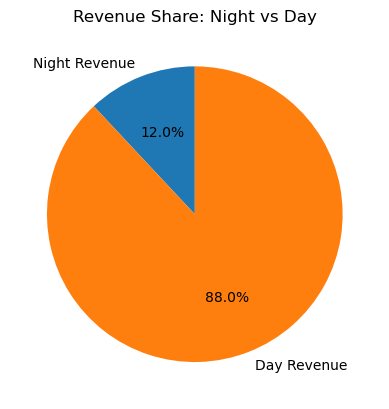

In [75]:
labels = ['Night Revenue', 'Day Revenue']
sizes = [night_share, day_share]
plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Revenue Share: Night vs Day')
plt.show()

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [76]:
# Analyse the fare per mile per passenger for different passenger counts
df['fair_distance'] = df['fare_amount'] / df['trip_distance']
df['fair_distance_passenger'] = df['fair_distance'] / df['passenger_count']
pass_df = df.groupby('passenger_count')['fair_distance_passenger'].mean()
pass_df

passenger_count
1.0    10.858597
2.0     6.427146
3.0     3.908226
4.0     4.363399
5.0     1.709614
6.0     1.350823
Name: fair_distance_passenger, dtype: float64

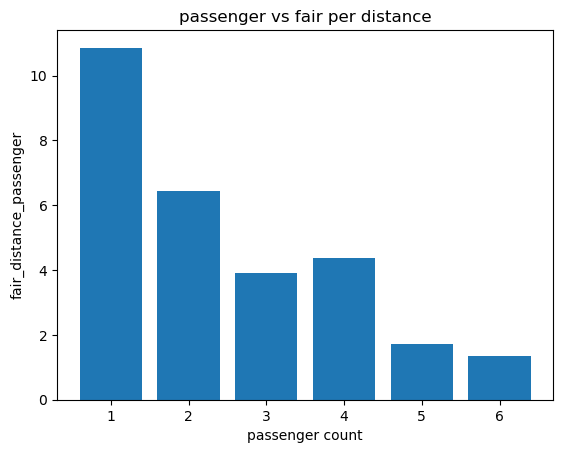

In [77]:
plt.figure()
plt.bar(pass_df.index, pass_df.values)
plt.xlabel('passenger count')
plt.ylabel('fair_distance_passenger')
plt.title('passenger vs fair per distance')
plt.show()

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [78]:
# Compare the average fare per mile for different days and for different times of the day
def get_time_quarter(hour):
    if hour <= 5:
        return 'Night'
    elif hour <= 11:
        return 'Morning'
    elif hour <= 17:
        return 'Afternoon'
    else:
        return 'Evening'
df['time_quarter'] = df['pickup_hour'].apply(get_time_quarter)

fare_mile_hours = (df.groupby(['week_day_name', 'time_quarter'])['fair_distance'].mean().unstack())
fare_mile_hours

time_quarter,Afternoon,Evening,Morning,Night
week_day_name,,,,
Friday,12.112367,10.145505,10.429088,10.143152
Monday,12.116818,10.129772,10.179808,11.756342
Saturday,11.994899,10.561485,10.214735,9.964405
Sunday,13.168680,13.182691,11.510064,11.167104
Thursday,12.955542,9.912407,10.820563,10.914571
Tuesday,12.122784,10.512531,10.996939,14.954089
Wednesday,12.014828,10.430021,10.354680,13.773689


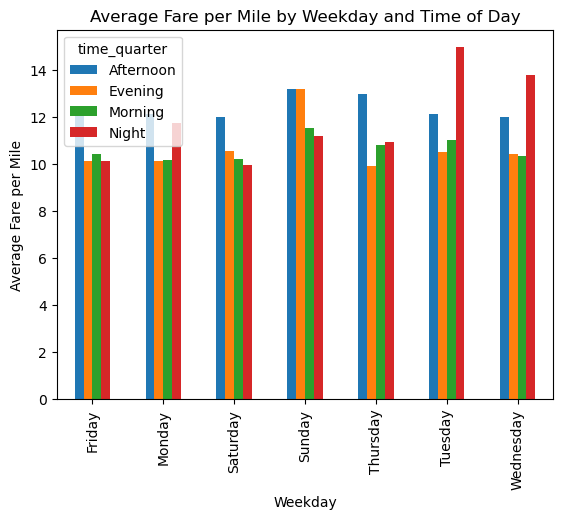

In [79]:
fare_mile_hours.plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile by Weekday and Time of Day')
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [80]:
# Compare fare per mile for different vendors
fare_mile = df.groupby('VendorID')['fair_distance'].mean()
fare_mile

VendorID
1     8.130864
2    12.395221
Name: fair_distance, dtype: float64

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [81]:
# Defining distance tiers
def distance_tier(dist):
    if dist <= 2:
        return 'Up to 2 miles'
    elif dist <= 5:
        return '2 to 5 miles'
    else:
        return 'More than 5 miles'

df['distance_tier'] = df['trip_distance'].apply(distance_tier)
vendor_distance = (df.groupby(['VendorID', 'distance_tier'])['fair_distance'].mean().unstack())
vendor_distance

distance_tier,2 to 5 miles,More than 5 miles,Up to 2 miles
VendorID,,,
1,6.381275,4.425189,9.929377
2,6.549310,4.502880,17.912767


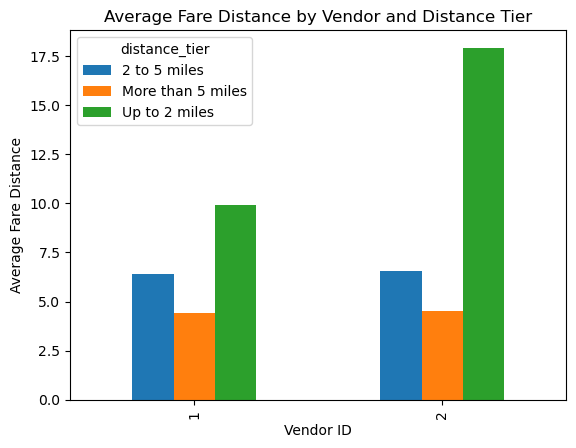

In [82]:
vendor_distance.plot(kind='bar')
plt.xlabel('Vendor ID')
plt.ylabel('Average Fare Distance')
plt.title('Average Fare Distance by Vendor and Distance Tier')
plt.show()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [83]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
df['tip_percent'] = (df['tip_amount'] / df['fare_amount'])*100

tip_by_distance = df.groupby('distance_tier')['tip_percent'].mean()

print("Average tip percentage by distance:")
print(tip_by_distance)

tip_by_passenger = df.groupby('passenger_count')['tip_percent'].mean()

print("\nAverage tip percentage by passenger count:")
print(tip_by_passenger)


tip_by_hour = df.groupby('pickup_hour')['tip_percent'].mean()

print("\nAverage tip percentage by pickup hour:")
print(tip_by_hour)

Average tip percentage by distance:
distance_tier
2 to 5 miles         18.766835
More than 5 miles    17.641587
Up to 2 miles        22.419249
Name: tip_percent, dtype: float64

Average tip percentage by passenger count:
passenger_count
1.0    20.937584
2.0    19.731155
3.0    19.027318
4.0    17.454256
5.0    20.490034
6.0    20.603345
Name: tip_percent, dtype: float64

Average tip percentage by pickup hour:
pickup_hour
0     20.502665
1     20.665673
2     20.651999
3     20.512864
4     18.250806
5     17.485191
6     18.467202
7     19.604960
8     20.047415
9     19.707164
10    19.243157
11    19.195872
12    19.134609
13    19.060210
14    19.031737
15    19.012862
16    20.916245
17    24.519772
18    22.237611
19    22.180046
20    21.496321
21    21.517316
22    21.300315
23    20.657642
Name: tip_percent, dtype: float64


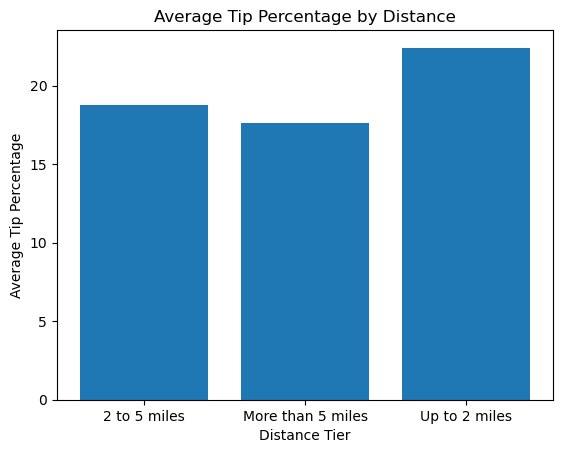

In [84]:
plt.figure()
plt.bar(tip_by_distance.index, tip_by_distance.values)
plt.xlabel('Distance Tier')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage by Distance')
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [85]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
df_10  = df[df['tip_percent'] <= 10]
df_25 = df[df['tip_percent'] >= 25]
x = df_10.groupby('distance_tier')['tip_percent'].mean()
print(f'10 % tip vs distance{x}\n')
y = df_25.groupby('distance_tier')['tip_percent'].mean()
print(f'25 % tip vs distance{y}')

10 % tip vs distancedistance_tier
2 to 5 miles         1.622333
More than 5 miles    1.278964
Up to 2 miles        0.923111
Name: tip_percent, dtype: float64

25 % tip vs distancedistance_tier
2 to 5 miles         29.060810
More than 5 miles    34.849728
Up to 2 miles        33.260444
Name: tip_percent, dtype: float64


<Figure size 640x480 with 0 Axes>

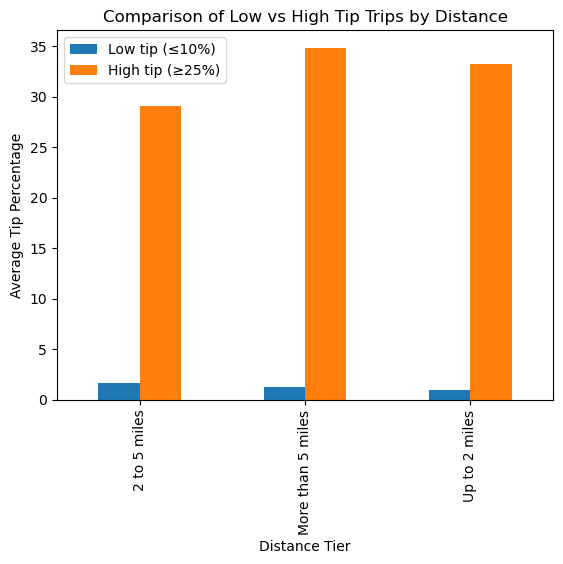

In [86]:
#Graph to visualize
compare_df = pd.DataFrame({'Low tip (≤10%)': x, 'High tip (≥25%)': y})
plt.figure()
compare_df.plot(kind='bar')
plt.xlabel('Distance Tier')
plt.ylabel('Average Tip Percentage')
plt.title('Comparison of Low vs High Tip Trips by Distance')
plt.show()

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [87]:
# See how passenger count varies across hours and days
x = df.groupby(['week_day_name', 'pickup_hour'])['passenger_count'].sum()
x_df = x.unstack()
print(x_df.head())

pickup_hour         0        1        2       3       4       5       6   \
week_day_name                                                              
Friday         10923.0   6224.0   3595.0  2112.0  1429.0  2007.0  4668.0   
Monday          5195.0   2729.0   1396.0  1036.0  1026.0  1832.0  4818.0   
Saturday       18188.0  14833.0  10995.0  6964.0  3376.0  1399.0  2616.0   
Sunday         19255.0  15942.0  11544.0  7893.0  4182.0  1749.0  2544.0   
Thursday        7574.0   3743.0   2003.0  1225.0  1096.0  1917.0  5283.0   

pickup_hour         7        8        9   ...       14       15       16  \
week_day_name                             ...                              
Friday          9428.0  12861.0  14710.0  ...  22208.0  23386.0  22877.0   
Monday          9625.0  13166.0  14358.0  ...  20214.0  21283.0  20937.0   
Saturday        4190.0   7150.0  11386.0  ...  22149.0  23384.0  24144.0   
Sunday          3982.0   6254.0  10471.0  ...  21447.0  21019.0  21238.0   
Thursday   

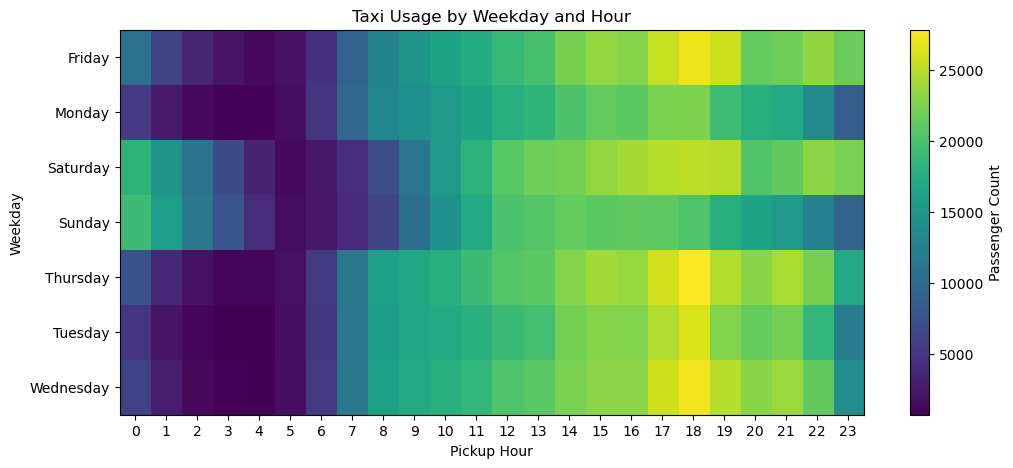

In [88]:
plt.figure(figsize=(12, 5))
plt.imshow(x_df, aspect='auto')

plt.colorbar(label='Passenger Count')

plt.xticks(range(len(x_df.columns)), x_df.columns)
plt.yticks(range(len(x_df.index)), x_df.index)

plt.xlabel('Pickup Hour')
plt.ylabel('Weekday')
plt.title('Taxi Usage by Weekday and Hour')

plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [89]:
# How does passenger count vary across zones
avg_zone_pass = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_zone_pass

,PULocationID,passenger_count
0,1,1.319149
1,2,1.000000
2,3,1.000000
3,4,1.436053
4,5,1.000000
...,...,...
250,261,1.544986
251,262,1.329785
252,263,1.337988
253,264,1.347267


In [90]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
zones_with_trips = zones.merge(avg_zone_pass, left_on='LocationID', right_on='PULocationID', how='left')
zones_with_trips

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,passenger_count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,1.319149
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0,1.000000
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",3.0,1.000000
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,1.436053
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",5.0,1.000000
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",259.0,1.057143
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",260.0,1.321192
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",261.0,1.544986
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",262.0,1.329785


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [91]:
# How often is each surcharge applied?
df['surcharge'] = (df['congestion_surcharge'] > 0).astype(int)
pickup_surcharge = (df.groupby('PULocationID')['surcharge'].mean() * 100).sort_values(ascending=False)
drop_surcharge = (df.groupby('DOLocationID')['surcharge'].mean() * 100).sort_values(ascending=False)
print(f'pickup surcharge loction {pickup_surcharge.head(20)}')
print(f'dropoff surcharge loction {drop_surcharge.head(20)}')

pickup surcharge loction PULocationID
2      100.000000
59     100.000000
187    100.000000
237     99.792992
229     99.791369
141     99.759243
12      99.753998
249     99.733844
262     99.723228
114     99.687161
234     99.678044
79      99.646188
113     99.635168
239     99.616322
142     99.609962
224     99.576072
236     99.561699
140     99.532226
144     99.518934
148     99.503573
Name: surcharge, dtype: float64
dropoff surcharge loction DOLocationID
114    99.873752
237    99.862593
249    99.861244
144    99.860792
229    99.860288
113    99.849946
158    99.837662
246    99.831303
211    99.827380
224    99.826715
141    99.821555
239    99.817565
162    99.816790
163    99.811551
143    99.809488
142    99.806554
164    99.804833
234    99.802302
12     99.801980
13     99.800664
Name: surcharge, dtype: float64


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [92]:
top_routes = (df.groupby('time_quarter')['PULocationID'].value_counts().groupby(level=0).head(5))
print(top_routes)

time_quarter  PULocationID
Afternoon     237             37769
              161             35999
              236             35042
              132             33201
              138             25434
Evening       132             36900
              161             32117
              237             26594
              142             24582
              230             23431
Morning       236             22666
              237             20386
              186             18577
              132             16589
              162             15297
Night         79              11870
              249              8959
              132              8242
              148              7870
              48               7331
Name: count, dtype: int64


In [93]:
###""" The results show that certain routes, based on pickup locations, are used more frequently during specific times of the day.
###""" By pre-positioning taxis at high-demand pickup locations along these routes during the corresponding time periods,
###""" passenger wait times can be reduced and dispatch efficiency can be improved.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [94]:
top_routes_by_time = (df.groupby(['month', 'week_day_name', 'pickup_hour'])['PULocationID'].value_counts().groupby(level=[0, 1, 2]).head(3))
print(top_routes_by_time)

month      week_day_name  pickup_hour  PULocationID
April      Friday         0            79              46
                                       249             41
                                       132             38
                          1            249             38
                                       132             37
                                                       ..
September  Wednesday      22           132             65
                                       230             63
                          23           132             60
                                       138             47
                                       161             41
Name: count, Length: 6048, dtype: int64


In [95]:
###"""By positioning cabs in high-demand pickup zones identified for specific hours, days, and months, operators can reduce idle time,
### minimize passenger wait times, and improve overall fleet utilization."""

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [96]:
zone_demand = df.groupby('PULocationID').size().sort_values(ascending=False)
zone_fare = df.groupby('PULocationID')['fare_amount'].mean()
zone_pricing_signal = pd.DataFrame({'trip_count': zone_demand, 'avg_fare': zone_fare})
zone_pricing_signal.head(10)

,trip_count,avg_fare
PULocationID,,
1,47,76.394681
2,2,70.000000
3,31,31.887097
4,1814,16.200276
5,9,62.533333
6,22,14.490909
7,739,18.386536
8,4,54.712500
9,24,29.866667


In [97]:
### """ Zones with higher trip volumes and higher average fares indicate strong demand and pricing power,
### and can be prioritized for slight fare premiums, while low-demand zones can use competitive pricing to maintain ridership."""